In [95]:
import math
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
from scipy.stats import t

## Created functions

In [96]:
def temp_health_penalty(temp):
    if 3 <= temp <= 5:
        return 0.1
    return abs(temp - 4)**2 * 0.05

def salinity_health_penalty(salinity):
    sigma = 1.5
    return 1 - math.exp(-((salinity - 34)**2) / (2 * sigma**2))

def depth_health_penalty(depth):
    if 50 <= depth <= 200:
        return 0.1
    return abs(depth - 125) / 100

In [105]:
def hunt(df=4, scale=1.0, success_chance=0.8):
    """
    Returns health gain from a hunting attempt.
    - df: degrees of freedom for the t-distribution.
    - scale: spread of the distribution (like std dev).
    - success_chance: probability the slug successfully hunts that day.
    """
    if random.random() > success_chance:
        return 0  # Failed hunt = no gain
    
    # Sample from a t-distribution (heavy tails, centered around 0)
    gain = t.rvs(df=df) * scale
    
    # Clamp to non-negative values (or optionally allow negative = exhaustion)
    return max(0, round(gain, 2))

In [106]:
def daily_health_penalty(temp, salinity, depth):
    """
    Calculates total daily health penalty based on environmental conditions.
    """
    temp_penalty = temp_health_penalty(temp)
    sal_penalty = salinity_health_penalty(salinity)
    depth_penalty = depth_health_penalty(depth)
    #print(temp_penalty,sal_penalty,depth_penalty)

    return temp_penalty + sal_penalty + depth_penalty


## Create the Sea Slug class

In [ ]:
class SeaSlug:
    def __init__(self):
        self.age = 0
        self.health = 100.0
        self.energy = 100.0
        self.reproductive_success = 0
        self.alive = True
    def step(self, temp, salinity, depth):
        if not self.alive:
            return
        
        self.health = min(100, self.health + hunt())
        penalty = daily_health_penalty(temp, salinity, depth)
        self.health -= penalty
        self.energy -= 1  # Daily maintenance cost

        # Reproduction logic placeholder
        if self.energy > 90 and self.health > 80:
            self.reproductive_success += 0.1

        self.age += 1

        if self.age > 100 or self.health <= 0 or self.energy <= 0:
            self.alive = False


## Simulate

In [124]:
slugs = [SeaSlug() for _ in range(1000)]

for day in range(365 * 10):  # 10 years
    for slug in slugs:
        slug.step(temp=10.0, salinity=34.0, depth=100)

# After simulation: analyze output
lifespans = [slug.age for slug in slugs]
repro_rates = [slug.reproductive_success for slug in slugs]


In [125]:
print("Average lifespan:", sum(lifespans)/len(slugs))
print("Average reproduction:", sum(repro_rates)/len(slugs))


Average lifespan: 66.876
Average reproduction: 1.2683


## Visualisation

In [126]:
lifespans = [slug.age for slug in slugs]

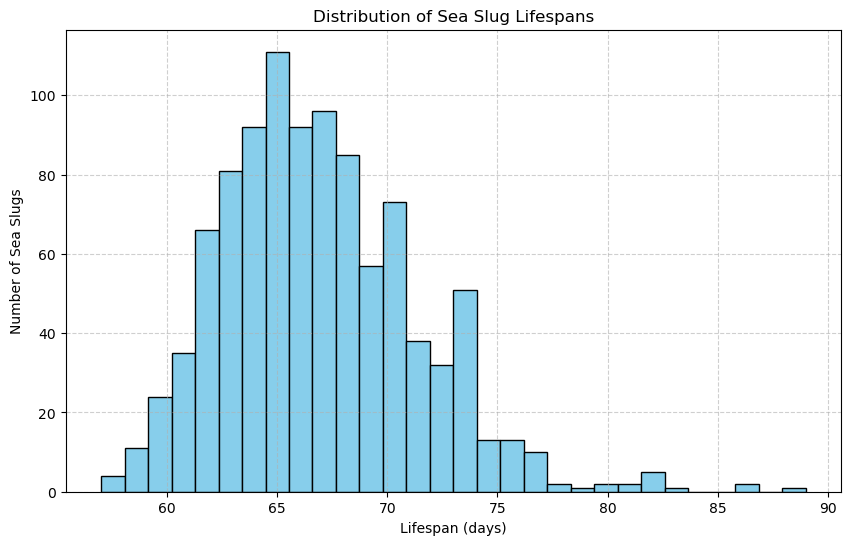

In [127]:
plt.figure(figsize=(10, 6))
plt.hist(lifespans, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Sea Slug Lifespans")
plt.xlabel("Lifespan (days)")
plt.ylabel("Number of Sea Slugs")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

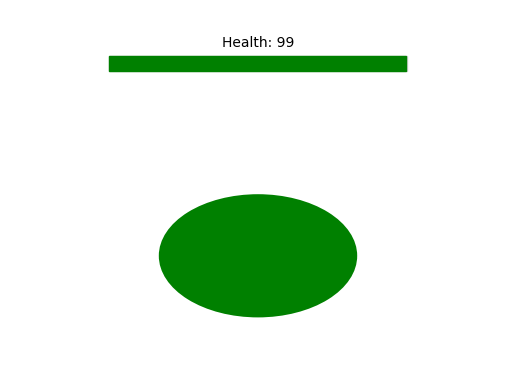

In [104]:
# Setup
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.2)
ax.axis('off')

# Blob (the sea slug)
blob = plt.Circle((0.5, 0.4), 0.2, fc='green')
ax.add_patch(blob)

# Health bar background
bar_bg = plt.Rectangle((0.2, 1.0), 0.6, 0.05, color='lightgray')
ax.add_patch(bar_bg)

# Health bar foreground (this updates)
bar_fg = plt.Rectangle((0.2, 1.0), 0.6, 0.05, color='green')
ax.add_patch(bar_fg)

# Health text
health_text = ax.text(0.5, 1.07, "Health: 100", ha='center', va='bottom', fontsize=10)

# Slug instance
slug = SeaSlug()

# Update function
def update(frame):
    slug.step(temp=4, salinity=34.0, depth=100)

    # Update blob color
    if not slug.alive:
        color = 'black'
    elif slug.health > 70:
        color = 'green'
    elif slug.health > 30:
        color = 'orange'
    else:
        color = 'red'

    blob.set_facecolor(color)

    # Update health bar width and color
    bar_width = max(slug.health / 100.0 * 0.6, 0)
    bar_fg.set_width(bar_width)

    if slug.health > 70:
        bar_fg.set_color('green')
    elif slug.health > 30:
        bar_fg.set_color('orange')
    else:
        bar_fg.set_color('red')

    # Update health text
    health_text.set_text(f"Health: {int(slug.health)}")

    return blob, bar_fg, health_text

ani = animation.FuncAnimation(fig, update, frames=200, interval=100, blit=True)
plt.show()
